# Introduction
This tutorial provides an example of how to use the [its_live API](https://staging.nsidc.org/apps/itslive-search/docs#/default/urls_velocities_urls__get) to use NASA its_live velocity image-pairs data stored in the cloud. This bypasses the need to download the velocities which we did in the `its_live_web_app_tutorial.ipynb` tutorial. Speficially, we will use the `urls` part of the API

In [1]:
import requests
import xarray as xr
import os
import json
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import s3fs
import iceutils as ice
import rasterio
from rasterio.plot import show
from matplotlib import colors, cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Step 1: Define your region of interest 
I created a polygon in QGIS similar to that of the polygon we drew in the `its_live_web_app_tutorial.ipynb`. Below I read that polygon using `geopandas`' read_file method

In [2]:
store_poly_path = '/media/laserglaciers/upernavik/its_live_tutorial/geoms/store_poly.shp'
store_poly = gpd.read_file(store_poly_path)

## Step 2: Convert polygon to proper string format

The its_live api requires specific sytanx for its's `polygon` and `bbox` parameter. For `bbox` it is "Bbox: min_lon,min_lat,max_lon,max_lat" and for `polygon` it is "lon_1,lat_1,lon_2,lat_2,..."

In [3]:
exterior_coords = list(store_poly['geometry'][0].exterior.coords)
# make string list to match the correct format
poly_string = f"{exterior_coords}".strip("[]")
poly_string = poly_string.replace('(','').replace(')','')

bbox = "-50.5877959318467063,70.3796049883689250 ,-50.2509403990491563,70.4921539185926918" # just a test for bbox parameter

As you can see, the poly_string now matched the correct format for the `polygon` parameter

In [4]:
poly_string

'-50.45417579726429, 70.39259671463697, -50.536348731615135, 70.37960498836892, -50.587795931846706, 70.39342772346002, -50.580830436256754, 70.40916334718578, -50.517852377688946, 70.42672250385142, -50.449540861970135, 70.44399543559763, -50.41104445188681, 70.46244888198, -50.38018041105781, 70.48538988092797, -50.32924599073642, 70.49215391859269, -50.252638946456926, 70.47600804789774, -50.250940399049156, 70.45108603336654, -50.31951241771743, 70.42484788496357, -50.39799740804242, 70.40257031942717, -50.45417579726429, 70.39259671463697'

## Step 3: Fetch the image-pair velocity urls

The cell below is modified from the [main its_live webpage](https://its-live.jpl.nasa.gov/) on how to use the its_live API. This is pretty much the same as the pop up we filled out in the `its_live_web_app_tutorial`. Though here we use python's `requests` library to return the urls of interest

In [5]:
base_url = "https://nsidc.org/apps/itslive-search/velocities/urls/"
# store
params = {
  "polygon": f"{poly_string}",
  "start": "2019-01-01",
  "end": "2021-05-01",
  "percent_valid_pixels": 50, # percent of valid glacier pixels
  "min_interval": 7, # days of separation between image pairs
  "max_interval": 14, # days of separation between image pairs
  "version": 2, # version 1 requires an EDL access token header in the request
  "mission":'S2'
}
# This will return a list of NetCDF files in AWS S3 that can be accessed
# in the cloud or externally
velocity_pairs = requests.get(base_url, params=params)
velocity_pairs

<Response [200]>

Below is how to turn the requests return into a json so we can easily modify it and grab an image-pair velocity url. We then open the file and calculate the strain rates using [`iceutils`](https://github.com/bryanvriel/iceutils)

## Step 4: Read the data and calculate strain rates

In [6]:
API_Data = velocity_pairs.json()
s3_url = API_Data[1]['url'].replace('https','s3').replace('.s3.amazonaws.com','')

# https://gis.stackexchange.com/questions/429000/error-trying-to-open-netcdf-file-with-xarray-from-s3-bucket
fs = s3fs.S3FileSystem(anon=True)
    
with fs.open(s3_url) as fileObj:
    ds = xr.open_dataset(fileObj, engine='h5netcdf')
    # ds.v.plot(vmin=0,vmax=3000)
    dx = ds.chip_size_width.attrs['x_pixel_size']
    dy = ds.chip_size_height.attrs['y_pixel_size'] *-1
    
    #compute strain rates and rotate to flow direction
    strain_dict, stress_dict = ice.compute_stress_strain(ds.vx.data, ds.vy.data, dx=100, dy=-100,
                                                     rotate=True)
    e_xx = strain_dict['e_xx']
    e_yy = strain_dict['e_yy']
    e_xy = strain_dict['e_xy']
    

FileNotFoundError: its-live-data/velocity_image_pair/sentinel2-latest/N70W040/S2B_MSIL1C_20210421T151759_N0300_R068_T22WED_20210421T190156_X_S2B_MSIL1C_20210501T151759_N0300_R068_T22WED_20210501T185834_G0120V02_P098.nc

Now let's visualize the longitudinal strain rate $\dot{\epsilon}_{xx}$ and see what it looks like!

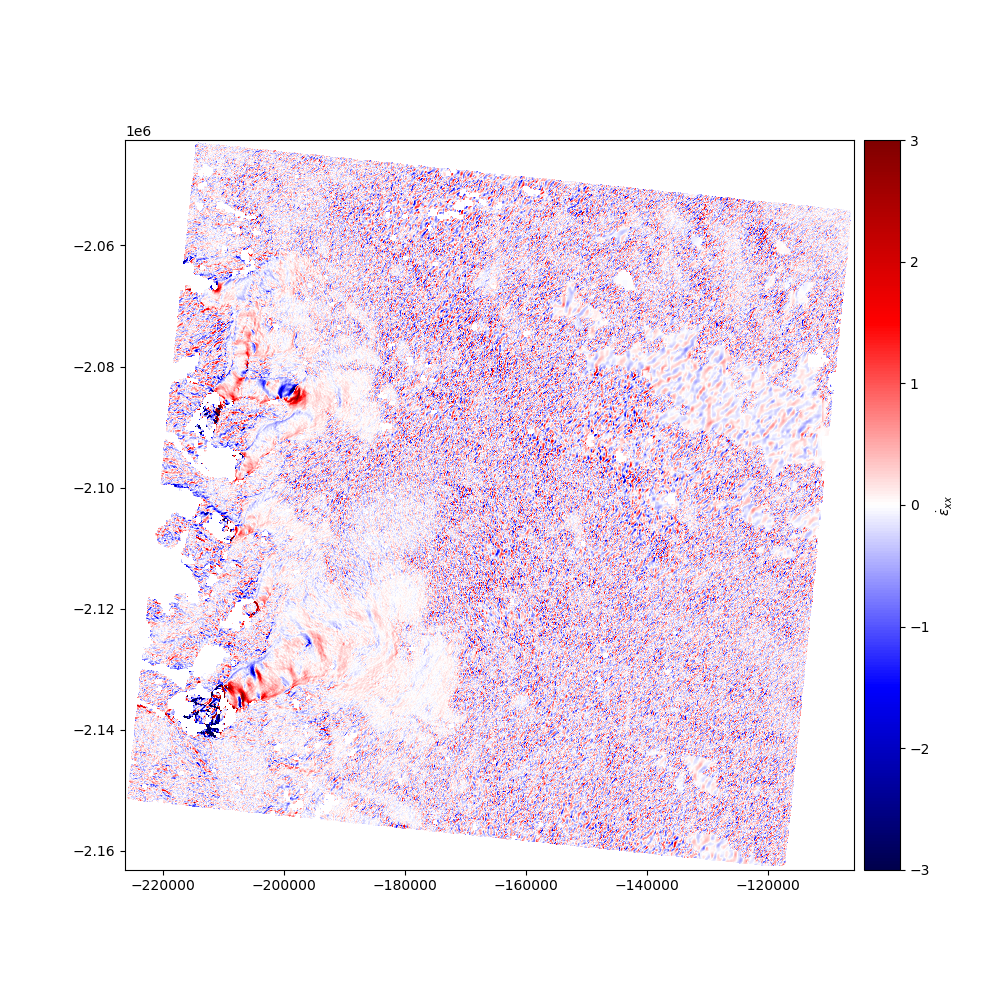

In [7]:
%matplotlib widget
ds.rio.transform()
fig, ax = plt.subplots(figsize=(10,10))
cmap = plt.get_cmap('seismic').copy()
vmin,vmax= -3,3
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin = vmin,vmax = vmax), cmap=cmap),
              cax=cax,label='$\dot{\epsilon}_{xx}$')
exx_image = show(e_xx,vmin=vmin,vmax=vmax,cmap=cmap,transform=ds.rio.transform(),ax=ax)